# Análise de Dados do ENEM Edições 2017, 2018 e 2019
### Parte 3
___

### Pergunta 6 - Qual a renda média dos participantes por estado?

#### Importando as bibliotecas para análise de dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import sqlite3
import warnings
import os
import geopandas as gpd
warnings.filterwarnings('ignore')

Importando o conjunto de dados remodelado com os dados das edições do ENEM de 2017 até 2019.

In [2]:
dados_enem = pd.read_csv('DADOS/dados_enem_2017_ate_2019.csv',sep=';', encoding='ISO-8859-1')

Dados obtidos do dicionário de dados do ENEM.
Estes dados indicam a faixa de renda dos participantes do ENEM

In [5]:
dict_renda = {
    'A':0,
    'B':937.00,
    'C':1405.50,
    'D':1874.00,
    'E':2342.50,
    'F':2811.00,
    'G':3748.00,
    'H':4685.00,
    'I':5622.00,
    'J':6559.00,
    'K':7496.00,
    'L':8433.00,
    'M':9370.00,
    'N':11244.00,
    'O':14055.00,
    'P':18740.00,
    'Q':18740.00
}

Acrescentando os valores de renda no conjunto de dados de acordo com a classificação de renda da coluna "Q006"

In [6]:
temp = pd.DataFrame(data={"Q006":dict_renda.keys(), "VALOR_RENDA":dict_renda.values()})

In [7]:
temp.head()

,Q006,VALOR_RENDA
0,A,0.0
1,B,937.0
2,C,1405.5
3,D,1874.0
4,E,2342.5


Vamos combinar o data frame temporário criado acima com o conjunto de dados do enem para obtermos a coluna VALOR_RENDA.

In [8]:
dados_enem = dados_enem.merge(temp, on='Q006', how='left', validate='m:1')

In [9]:
dados_enem.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,NO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_ESC,CO_ESCOLA,SG_UF_ESC,Q006,AREA_CON,NOTAS,VALOR_RENDA
0,0,170001663652,2017,Itacoatiara,Itacoatiara,13079220.0,AM,P,Ciências da Natureza,540.7,18740.0
1,1,170001664222,2017,Salvador,Salvador,29422418.0,BA,Q,Ciências da Natureza,396.4,18740.0
2,2,170001665543,2017,São Paulo,São Paulo,35001259.0,SP,F,Ciências da Natureza,452.8,2811.0
3,3,170001663747,2017,Santa Bárbara d'Oeste,Santa Bárbara d'Oeste,35925950.0,SP,D,Ciências da Natureza,496.0,1874.0
4,4,170003333557,2017,Lapão,Irecê,29428408.0,BA,B,Ciências da Natureza,591.1,937.0


In [10]:
del dados_enem['Unnamed: 0']

Agora, vamos importar o conjunto de [dados de geolocalização](https://www.kaggle.com/thiagobodruk/brazil-geojson/version/1) (para construir o gráfico de mapa obtidos) do Kaggle que nos fornecerá os nomes dos estados para cada UF.


In [11]:
estados_brasil = json.load(open("DADOS/brazil_geo.json", "r", encoding='UTF-8'))

Utilizando o arquivo json para obter um dicionário com as siglas e nomes dos estados brasileiros

In [12]:
state_id_map = {}
for feature in estados_brasil["features"]:
    feature["id"] = feature["id"]
    state_id_map[feature["id"]] = feature["properties"]["name"]

Visualizando o conjunto de dados do dicionário

In [13]:
state_id_map

{'AC': 'Acre',
 'AL': 'Alagoas',
 'AP': 'Amapá',
 'AM': 'Amazonas',
 'BA': 'Bahia',
 'CE': 'Ceará',
 'DF': 'Distrito Federal',
 'ES': 'Espírito Santo',
 'GO': 'Goiás',
 'MA': 'Maranhão',
 'MT': 'Mato Grosso',
 'MS': 'Mato Grosso do Sul',
 'MG': 'Minas Gerais',
 'PA': 'Pará',
 'PB': 'Paraíba',
 'PR': 'Paraná',
 'PE': 'Pernambuco',
 'PI': 'Piauí',
 'RJ': 'Rio de Janeiro',
 'RN': 'Rio Grande do Norte',
 'RS': 'Rio Grande do Sul',
 'RO': 'Rondônia',
 'RR': 'Roraima',
 'SC': 'Santa Catarina',
 'SP': 'São Paulo',
 'SE': 'Sergipe',
 'TO': 'Tocantins'}

Calculando a renda média por estado.

In [21]:
renda_por_uf = dados_enem.groupby(['SG_UF_ESC'], as_index=False).mean()[['SG_UF_ESC','VALOR_RENDA', 'NOTAS']]
renda_por_uf['ESTADO'] = [state_id_map[renda_por_uf['SG_UF_ESC'][i]] for i in renda_por_uf.index]
renda_por_uf['ESTADO'] = renda_por_uf['ESTADO'].str.upper()
renda_por_uf.sort_values(by='VALOR_RENDA', ascending=False)

renda_por_uf.head()

,SG_UF_ESC,VALOR_RENDA,NOTAS,ESTADO
0,AC,1821.090392,402.554686,ACRE
1,AL,1818.676995,419.212433,ALAGOAS
2,AM,1795.338649,363.965889,AMAZONAS
3,AP,1968.956215,405.769938,AMAPÁ
4,BA,1902.552693,425.232271,BAHIA


Agora vamos importar o arquivo que possui as estruturas geométricas (.shp) dos estados brasileiros para combinar os dados de renda com os dados de geometria. Isto nos permitirá plotar um grágico de mapa. Para isto, utilizaremos a biblioteca **geopandas** para ler o arquivo .shp. A recomendação de instalação dessa biblioteca é por meio do Anaconda, usando o comando ```conda install geopandas```. Os arquivos shapefile podem ser encontrados clicando [neste link](ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2017/Brasil/BR). Basta escolher o arquivo *BR_UF_2021.zip*.

In [22]:
br_map = gpd.read_file('DADOS/shapes/BRUFE250GC_SIR.shp') # Lê o arquivo .shp
br_map = br_map.rename(columns={'NM_ESTADO':'ESTADO'}) # Renomeia a coluna 'NM_ESTADO'
br_map = br_map.merge(renda_por_uf, on='ESTADO', how='left') # une o mapa com os dados

Criando o gráfico de mapa da distribuição média de renda dos participantes por estado

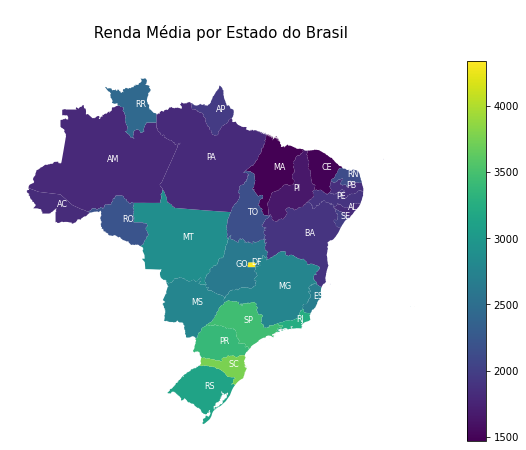

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))


ax.spines[['right','top','left','bottom']].set_visible(False) # Oculta as linhas dos eixos
ax.get_xaxis().set_visible(False)                             # Oculta os valores do eixo x
ax.get_yaxis().set_visible(False)                             # Oculta os valores do eixo y
ax.set_title('\n Renda Média por Estado do Brasil \n', fontdict={'fontsize':15}) # Adiciona o título do gráfico

br_map["center"] = br_map["geometry"].centroid             # Adiciona um centroide na estrututa geopandas
br_map_points = br_map.copy()                              # Copia o geodataframe
br_map_points.set_geometry("center", inplace = True)       # Faz que o centroide seja a geometria da estrutura

ax = br_map.plot(column='VALOR_RENDA', ax=ax, legend=True) # Plota o gráfico

texts = []                                                 # Criado para armazenar as siglas dos estados

# Inclui as siglas dos estados no gráfico de acordo com as cordenadas (x,y)
for x, y, label in zip(br_map_points.geometry.x, br_map_points.geometry.y, br_map_points["SG_UF_ESC"]):
    texts.append(plt.text(x, y, label, fontsize = 8, color='white'))   

In [17]:
fig.savefig('images/mapa_renda_media.png', dpi=400)

---

### Pergunta 7 - Qual a nota média por estado?

Agora vamos construir um gráfico de mapa para visualizar a nota média por estado.

Plotando um gráfico de mapa para visualizar como a nota média está distribuída pelos estados

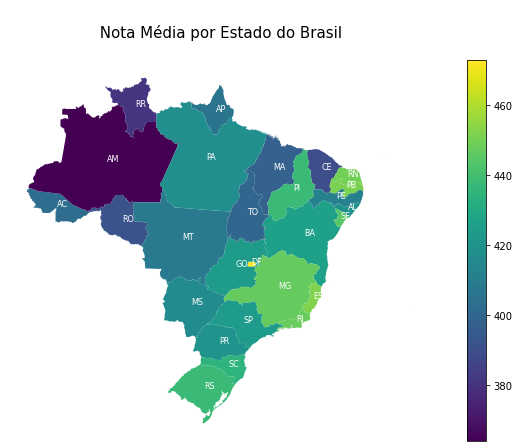

In [24]:
fig, ax = plt.subplots(figsize=(12, 7))


ax.spines[['right','top','left','bottom']].set_visible(False) # Oculta as linhas dos eixos
ax.get_xaxis().set_visible(False)                             # Oculta os valores do eixo x
ax.get_yaxis().set_visible(False)                             # Oculta os valores do eixo y
ax.set_title('\n Nota Média por Estado do Brasil \n', fontdict={'fontsize':15}) # Adiciona o título do gráfico

br_map["center"] = br_map["geometry"].centroid             # Adiciona um centroide na estrututa geopandas
br_map_points = br_map.copy()                              # Copia o geodataframe
br_map_points.set_geometry("center", inplace = True)       # Faz que o centroide seja a geometria da estrutura

ax = br_map.plot(column='NOTAS', ax=ax, legend=True) # Plota o gráfico

texts = []                                                 # Criado para armazenar as siglas dos estados

# Inclui as siglas dos estados no gráfico de acordo com as cordenadas (x,y)
for x, y, label in zip(br_map_points.geometry.x, br_map_points.geometry.y, br_map_points["SG_UF_ESC"]):
    texts.append(plt.text(x, y, label, fontsize = 8, color='white')) 

In [25]:
# Salvando a imagem do gráfico
fig.savefig('images/mapa_notas_media.png', dpi=400)

---

### Pergunta 8 - Quais são as 10 escolas com maior nota final no ENEM?

Removendo o ```.0``` das linhas da coluna ```CODIGO_ESC``` já que ela será nossa chave primária para fazer join com a tabela do Censo Escolar que possui os códigos e nomes da escola. Isto pode levar alguns segundos.

In [34]:
dados_enem['CO_ESCOLA'] = dados_enem['CO_ESCOLA'].astype(str)
dados_enem['CO_ESCOLA'] = dados_enem['CO_ESCOLA'].apply(lambda x: str(x).replace('.0', ''))

In [35]:
dados_enem.head()

,NU_INSCRICAO,NU_ANO,NO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_ESC,CO_ESCOLA,SG_UF_ESC,Q006,AREA_CON,NOTAS,VALOR_RENDA
0,170001663652,2017,Itacoatiara,Itacoatiara,13079220,AM,P,Ciências da Natureza,540.7,18740.0
1,170001664222,2017,Salvador,Salvador,29422418,BA,Q,Ciências da Natureza,396.4,18740.0
2,170001665543,2017,São Paulo,São Paulo,35001259,SP,F,Ciências da Natureza,452.8,2811.0
3,170001663747,2017,Santa Bárbara d'Oeste,Santa Bárbara d'Oeste,35925950,SP,D,Ciências da Natureza,496.0,1874.0
4,170003333557,2017,Lapão,Irecê,29428408,BA,B,Ciências da Natureza,591.1,937.0


Calculando a média por escola.

In [36]:
notas_por_esc = dados_enem.groupby(['CO_ESCOLA'], as_index=False).mean()[['CO_ESCOLA','NOTAS']]
notas_por_esc['NOTAS'] = [round(notas_por_esc['NOTAS'][i], 2) for i in notas_por_esc.index]
notas_por_esc.head()

,CO_ESCOLA,NOTAS
0,11000058,631.76
1,11000171,488.07
2,11000180,351.98
3,11000198,555.23
4,11000244,544.65


Importando o conjunto de dados do Censo Escolar, no qual é possível encontrar os nomes das escolas.
Você pode encontrar o arquivo no portal de [Dados do Censo Escolar do INEP](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/censo-escolar).

In [38]:
df_escolas = pd.read_csv('DADOS/ESCOLAS.csv', sep='|', encoding='ISO-8859-1', usecols= ['CO_ENTIDADE', 'NO_ENTIDADE'])

Visualizando as 2 primeiras linhas do conjunto de dados importado.

In [39]:
df_escolas.head(2)

,CO_ENTIDADE,NO_ENTIDADE
0,11022370,EMEIEF CARLOS CHAGAS
1,11022388,EMEIEF CARLOS GOMES


Convertendo o tipos dos dados das colunas "CO_ENTIDADE" para sttring

In [40]:
df_escolas['CO_ENTIDADE'] = df_escolas['CO_ENTIDADE'].astype(str)

Criando o um banco de dados SQLite para salvar os dados do arquivo de escolas do inep. Usaremos as colunas  "CODIGO_ESC" e "NO_ENTIDADE TEXT".
Assim, ao cruzar os dados com a base de dados do enem, conseguiremos obter o nome das escolas que tiveram melhor desempenho utilizando **linguagem SQL**.

In [45]:
con = sqlite3.connect("DADOS/escolas.db")
cur = con.cursor()
cur.execute("CREATE TABLE IF NOT EXISTS tbl_escola (CODIGO_ESC CHAR(10) PRIMARY KEY, NO_ENTIDADE TEXT)")

for i in range(0, len(df_escolas['CO_ENTIDADE'])):
    cur.execute("insert into tbl_escola values (?, ?)", (df_escolas['CO_ENTIDADE'][i], df_escolas['NO_ENTIDADE'][i]))

con.commit()

Agora vamos carregar a tabela com as notas do enem por escola no banco de dados

In [46]:
con = sqlite3.connect("DADOS/escolas.db")
cur = con.cursor()
cur.execute("CREATE TABLE IF NOT EXISTS tbl_escola_notas (CO_ESC CHAR(10) PRIMARY KEY, NOTA double)")

for i in range(0, len(notas_por_esc['CO_ESCOLA'])):

    cur.execute("insert into tbl_escola_notas (CO_ESC, NOTA) values (?, ?)",
                (notas_por_esc['CO_ESCOLA'][i],
                 notas_por_esc['NOTAS'][i]))
con.commit()   

Instrução SQL

In [47]:
consulta= '''SELECT CO_ESC, NOTA, NO_ENTIDADE FROM tbl_escola_notas
            INNER JOIN tbl_escola ON tbl_escola.CODIGO_ESC = tbl_escola_notas.CO_ESC ORDER BY NOTA DESC LIMIT 10;'''

Fazendo uma consulta SQL e combinando resultados pela busca em duas tabelas diferentes

In [48]:
resultado = pd.read_sql_query(consulta, con)

Abaixo, as 10 escolas que tiveram melhor desempenho médio no enem dos anos de 2017, 2018 e 2019

In [49]:
resultado

,CO_ESC,NOTA,NO_ENTIDADE
0,15221024,779.56,ESCOLA VESTIBULANDO KIDS
1,24078298,776.56,EDUCANDARIO NOSSA SENHORA DA CONCEICAO
2,53017048,771.34,COL PODION ENSINO FUNDAMENTAL
3,33181586,756.76,CENTRO EDUCACIONAL ESPACO INTEGRADO
4,23246847,755.18,FARIAS BRITO COLEGIO DE APLICACAO
5,31370185,746.72,CENTRO DE EDUCACAO INFANTIL COLEGIO CERP
6,35137406,746.48,VERTICE COLEGIO UNIDADE I
7,33063540,742.70,CPII - CAMPUS HUMAITA I
8,23246871,741.27,ARI DE SA CAVALCANTE SEDE MARIO MAMEDE COLEGIO
9,31349720,740.39,FIBONACCI COLEGIO


In [50]:
resultado.to_csv('DADOS/resultado_analise_enem',sep=';', encoding='ISO-8859-1')

___

# Muito Obrigado!

###### Para qualquer dúvida ou sugestão entrar em contato pelo email: lucasflopes012@gmail.com